In [1]:
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
from scipy.special import expit as sigmoid
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from tqdm import tqdm

In [2]:
models = [
    # "ConvNet_batch2048_weight1.0_secondpart_30k",
    "ConvNet_batch2048_secondpart_30k",
    # "ConvNet_batch2048_weight0_secondpart_30k",
    # "vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000",
    "phyloP",
    "phastCons",
]
model_renaming = {
    "ConvNet_batch2048_secondpart_30k": "GPN",
    # "ConvNet_batch2048_secondpart_30k": "repeat-weight-0.1",
    # "ConvNet_batch2048_secondpart_30k": "8 species",
    "ConvNet_batch2048_weight1.0_secondpart_30k": "repeat-weight-1",
    "ConvNet_batch2048_weight0_secondpart_30k": "repeat-weight-0",
    "vep/scratch/users/gbenegas/checkpoints/GPN_Arabidopsis_multispecies/ConvNet_ss_12k/checkpoint-12000": "1 species",
}

d = Path(f"output/variants/all")
V = pd.read_parquet(d / "variants.parquet")

for m in models:
    model_path = d / f"{m}.parquet"
    model_name = model_renaming.get(m, m)
    V[model_name] = pd.read_parquet(model_path)["score"].values
models = [model_renaming.get(m, m) for m in models]
V.consequence = V.consequence.str.replace("_variant", "")
V

,chrom,pos,ref,alt,AC,AF,consequence,GPN,phyloP,phastCons
0,1,266,G,A,82,0.040414,intergenic,-0.670362,0.813899,-0.000523
1,1,270,G,A,16,0.007886,intergenic,-0.406548,0.097275,-0.007196
2,1,276,T,G,16,0.007886,intergenic,-0.643284,0.493032,-0.000789
3,1,284,T,A,1,0.000493,intergenic,-0.779196,0.703100,-0.000292
4,1,286,T,A,1,0.000493,intergenic,-0.048531,1.644564,-0.000070
...,...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.773075,-0.285819
10697060,5,26975235,G,A,11,0.005421,intergenic,-1.822485,-0.267246,-0.259101
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.438794,-0.764734,-0.229109
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.521554,-0.862251,-0.094685


In [3]:
V.phyloP.isna().mean()

0.1415278061344683

In [4]:
fold_af = True
N_ACCESSIONS = 2029

# should actually be called MAF, not AF

if fold_af:
    fold_mask = V["AF"] > 0.5

    for m in models:
        if m in ["phyloP", "phastCons"]:
            continue
        V.loc[fold_mask, m] *= -1  # flip the sign of GPN scores

    V.loc[fold_mask, "AF"] = 1 - V.loc[fold_mask, "AF"]
    V.loc[fold_mask, "AC"] = N_ACCESSIONS - V.loc[fold_mask, "AC"]
V

,chrom,pos,ref,alt,AC,AF,consequence,GPN,phyloP,phastCons
0,1,266,G,A,82,0.040414,intergenic,-0.670362,0.813899,-0.000523
1,1,270,G,A,16,0.007886,intergenic,-0.406548,0.097275,-0.007196
2,1,276,T,G,16,0.007886,intergenic,-0.643284,0.493032,-0.000789
3,1,284,T,A,1,0.000493,intergenic,-0.779196,0.703100,-0.000292
4,1,286,T,A,1,0.000493,intergenic,-0.048531,1.644564,-0.000070
...,...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.773075,-0.285819
10697060,5,26975235,G,A,11,0.005421,intergenic,-1.822485,-0.267246,-0.259101
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.438794,-0.764734,-0.229109
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.521554,-0.862251,-0.094685


In [7]:
if fold_af:
    V["MAF"] = V.AF

In [6]:
if "phyloP" in models:
    V["abs(phyloP)"] = -V["phyloP"].abs()
    models.append("abs(phyloP)")

In [7]:
if not fold_af:
    V = V.query("AF < 0.5")
V

,chrom,pos,ref,alt,AC,AF,consequence,GPN,phyloP,phastCons,euclidean_distance,inner_product,cosine_similarity,abs(phyloP)
0,1,266,G,A,82,0.040414,intergenic,-0.670362,0.813899,-0.000523,-453.633667,17607380.0,0.994112,-0.813899
1,1,270,G,A,16,0.007886,intergenic,-0.406548,0.097275,-0.007196,-303.145508,17573102.0,0.997390,-0.097275
2,1,276,T,G,16,0.007886,intergenic,-0.643284,0.493032,-0.000789,-349.904541,17442796.0,0.996497,-0.493032
3,1,284,T,A,1,0.000493,intergenic,-0.779196,0.703100,-0.000292,-284.186218,17627580.0,0.997715,-0.703100
4,1,286,T,A,1,0.000493,intergenic,-0.048531,1.644564,-0.000070,-319.998108,17569016.0,0.997090,-1.644564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.773075,-0.285819,-384.926941,20052408.0,0.996308,-0.773075
10697060,5,26975235,G,A,11,0.005421,intergenic,-1.822485,-0.267246,-0.259101,-325.695251,20124792.0,0.997359,-0.267246
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.438794,-0.764734,-0.229109,-318.942993,20277896.0,0.997482,-0.764734
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.521554,-0.862251,-0.094685,-271.911499,20270636.0,0.998137,-0.862251


In [8]:
"""
plt.figure(figsize=(2,2))
sns.histplot(
    data=V,
    x="GPN",
    bins=50,
    stat="density",
)
plt.axvline(0, linestyle="--", color="black")
plt.xlabel("GPN score")
sns.despine();
#plt.savefig("output/plots/gpn_score_hist.svg", bbox_inches="tight")
"""

'\nplt.figure(figsize=(2,2))\nsns.histplot(\n    data=V,\n    x="GPN",\n    bins=50,\n    stat="density",\n)\nplt.axvline(0, linestyle="--", color="black")\nplt.xlabel("GPN score")\nsns.despine();\n#plt.savefig("output/plots/gpn_score_hist.svg", bbox_inches="tight")\n'

In [9]:
"""
bins = np.arange(-9.5, 5.5)

V["bin"] = pd.cut(V.GPN, bins)
V["bin_midpoint"] = V.bin.apply(lambda x: x.mid)
plt.figure(figsize=(2,2))
g = sns.lineplot(
    data=V,
    x="bin_midpoint",
    y="AF",
    errorbar=None,
)
plt.xlabel("GPN score")
plt.ylabel("Mean AF")
sns.despine();
#plt.savefig("output/plots/gpn_score_vs_af.svg", bbox_inches="tight")
"""

'\nbins = np.arange(-9.5, 5.5)\n\nV["bin"] = pd.cut(V.GPN, bins)\nV["bin_midpoint"] = V.bin.apply(lambda x: x.mid)\nplt.figure(figsize=(2,2))\ng = sns.lineplot(\n    data=V,\n    x="bin_midpoint",\n    y="AF",\n    errorbar=None,\n)\nplt.xlabel("GPN score")\nplt.ylabel("Mean AF")\nsns.despine();\n#plt.savefig("output/plots/gpn_score_vs_af.svg", bbox_inches="tight")\n'

In [10]:
"""
V["GPN score"] = V.bin
plt.figure(figsize=(4,4))
g = sns.ecdfplot(
    data=V,
    hue="GPN score",
    x="AF",
    palette="viridis",
)
sns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))
sns.despine()
#plt.savefig("output/plots/gpn_score_vs_af_cdf.pdf", bbox_inches="tight")
"""

'\nV["GPN score"] = V.bin\nplt.figure(figsize=(4,4))\ng = sns.ecdfplot(\n    data=V,\n    hue="GPN score",\n    x="AF",\n    palette="viridis",\n)\nsns.move_legend(g, "upper left", bbox_to_anchor=(1, 1))\nsns.despine()\n#plt.savefig("output/plots/gpn_score_vs_af_cdf.pdf", bbox_inches="tight")\n'

In [11]:
V.GPN.min(), V.GPN.max()

(-11.430215, 10.397324)

In [36]:
bins = np.arange(-9.5, 8.5)
V["bin"] = pd.cut(V.GPN, bins)
V["bin_midpoint"] = V.bin.apply(lambda x: x.mid)
V.bin.value_counts()

bin
(-0.5, 0.5]     3531736
(-1.5, -0.5]    2554090
(0.5, 1.5]      1840889
(-2.5, -1.5]    1049310
(-3.5, -2.5]     506921
(1.5, 2.5]       371348
(-4.5, -3.5]     326326
(-5.5, -4.5]     200367
(-6.5, -5.5]     116400
(2.5, 3.5]        73264
(-7.5, -6.5]      53696
(3.5, 4.5]        30347
(-8.5, -7.5]      15817
(4.5, 5.5]        14276
(5.5, 6.5]         6337
(-9.5, -8.5]       2943
(6.5, 7.5]         2190
Name: count, dtype: int64

In [37]:
df = V.groupby("bin_midpoint").MAF.mean().reset_index()
df

/tmp/ipykernel_1769459/878091301.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = V.groupby("bin_midpoint").MAF.mean().reset_index()


,bin_midpoint,MAF
0,-9.0,0.009390
1,-8.0,0.012772
2,-7.0,0.016333
3,-6.0,0.018387
4,-5.0,0.019962
5,-4.0,0.022063
6,-3.0,0.025316
7,-2.0,0.029937
8,-1.0,0.035330
9,0.0,0.039408


/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


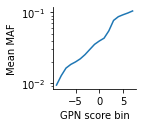

In [44]:
# new plot for review
plt.figure(figsize=(1.5, 1.5))
g = sns.lineplot(
    data=df,
    x="bin_midpoint",
    y="MAF",
    errorbar=None,
)
g.set(yscale="log")
plt.xlabel("GPN score bin")
plt.ylabel("Mean MAF")
sns.despine();
# plt.savefig("output/plots/gpn_score_vs_maf.svg", bbox_inches="tight")

In [11]:
consequences = [
    "all",
]
specific_consequences = V.consequence.value_counts()[:8].index.values.tolist()
consequences += specific_consequences
consequences

['all',
 'intergenic',
 'intron',
 'missense',
 'synonymous',
 'upstream_gene',
 'downstream_gene',
 '3_prime_UTR',
 '5_prime_UTR']

In [12]:
# conservation scores undefined in unaligned regions
V.dropna(inplace=True)
V

,chrom,pos,ref,alt,AC,AF,consequence,GPN,phyloP,phastCons,euclidean_distance,inner_product,cosine_similarity,abs(phyloP)
0,1,266,G,A,82,0.040414,intergenic,-0.670362,0.813899,-0.000523,-453.633667,17607380.0,0.994112,-0.813899
1,1,270,G,A,16,0.007886,intergenic,-0.406548,0.097275,-0.007196,-303.145508,17573102.0,0.997390,-0.097275
2,1,276,T,G,16,0.007886,intergenic,-0.643284,0.493032,-0.000789,-349.904541,17442796.0,0.996497,-0.493032
3,1,284,T,A,1,0.000493,intergenic,-0.779196,0.703100,-0.000292,-284.186218,17627580.0,0.997715,-0.703100
4,1,286,T,A,1,0.000493,intergenic,-0.048531,1.644564,-0.000070,-319.998108,17569016.0,0.997090,-1.644564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697059,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.773075,-0.285819,-384.926941,20052408.0,0.996308,-0.773075
10697060,5,26975235,G,A,11,0.005421,intergenic,-1.822485,-0.267246,-0.259101,-325.695251,20124792.0,0.997359,-0.267246
10697061,5,26975240,C,T,4,0.001971,intergenic,-3.438794,-0.764734,-0.229109,-318.942993,20277896.0,0.997482,-0.764734
10697062,5,26975245,G,A,7,0.003450,intergenic,-2.521554,-0.862251,-0.094685,-271.911499,20270636.0,0.998137,-0.862251


In [13]:
"""
from scipy.stats import pearsonr, spearmanr

for model in ["phyloP", "phastCons"]:
    print(model)
    print(pearsonr(V["GPN"], V[model]))
    print(spearmanr(V["GPN"], V[model]))
"""

'\nfrom scipy.stats import pearsonr, spearmanr\n\nfor model in ["phyloP", "phastCons"]:\n    print(model)\n    print(pearsonr(V["GPN"], V[model]))\n    print(spearmanr(V["GPN"], V[model]))\n'

In [14]:
V["Status"] = "Neither"

# default
V.loc[V.AC == 1, "Status"] = "Rare"
V.loc[V.AF >= 0.05, "Status"] = "Common"

# option 2
# V.loc[V.AC == 1, "Status"] = "Rare"
# V.loc[V.AF >= 0.01, "Status"] = "Common"

# option 3
# V.loc[V.AC <= 5, "Status"] = "Rare"
# V.loc[V.AF >= 0.05, "Status"] = "Common"

V = V[V.Status != "Neither"]
V.Status = V.Status.astype("category")
V.Status.value_counts()

/tmp/ipykernel_1633923/2391211216.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  V.Status = V.Status.astype('category')


Status
Rare      3013782
Common    1556193
Name: count, dtype: int64

In [15]:
from math import sqrt


def compute_odds_ratio(df, threshold_quantile, model_name):
    df = df.copy()
    threshold = df[model_name].quantile(threshold_quantile)
    df.loc[df[model_name] <= threshold, "ModelScoreTier"] = "Low"
    # df.loc[df[model_name] > df[model_name].quantile(0.1), "ModelScoreTier"] = "High"
    df.loc[df[model_name] > threshold, "ModelScoreTier"] = "High"
    df = df[df.ModelScoreTier.isin(["Low", "High"])]

    df.ModelScoreTier = df.ModelScoreTier.astype("category")
    group_counts = df.groupby(["Status", "ModelScoreTier"]).size()
    log_odds_se = sqrt(sum(1 / group_counts))  # "All of statistics" eq. 15.7
    group_counts2 = group_counts.copy()
    # print(group_counts2); raise Exception("debug")
    group_counts = group_counts.loc[
        pd.MultiIndex.from_tuples(
            [["Common", "High"], ["Common", "Low"], ["Rare", "High"], ["Rare", "Low"]]
        )
    ].values.reshape((2, 2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative="greater")
    log_odds_ratio = np.log(odds_ratio)
    ci_lower = np.exp(log_odds_ratio - 2 * log_odds_se)
    ci_upper = np.exp(log_odds_ratio + 2 * log_odds_se)
    # [ci_lower, ci_upper] is 95% CI
    if np.isinf(odds_ratio):
        print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts, ci_lower, ci_upper

In [16]:
import warnings

warnings.filterwarnings("ignore")


def get_subtitle(consequence, n_rare, n_common):
    c = consequence.replace("_variant", "")
    return f"{c}\nn={n_rare} vs. {n_common}"


threshold_quantiles = [1e-3, 1e-2, 1e-1]

rows = []
for c in tqdm(consequences):
    if c == "all":
        df_c = V.copy()
    else:
        df_c = V[V.consequence == c]
    df_c = df_c.dropna(subset=models)
    for m in models:
        subtitle = get_subtitle(
            c, (df_c.Status == "Rare").sum(), (df_c.Status == "Common").sum()
        )
        for tq in threshold_quantiles:
            # print(c, m, tq)
            OR, p_value, min_counts, cil, ciu = compute_odds_ratio(
                df_c[[m, "Status"]], tq, m
            )
            rows.append([m, c, tq, OR, p_value, min_counts, cil, ciu, subtitle])
results = pd.DataFrame(
    rows,
    columns=[
        "Model",
        "Consequence",
        "Threshold quantile",
        "Odds ratio",
        "p_value",
        "min_counts",
        "cil",
        "ciu",
        "subtitle",
    ],
)
results

100%|██████████| 9/9 [00:35<00:00,  3.96s/it]


,Model,Consequence,Threshold quantile,Odds ratio,p_value,min_counts,cil,ciu,subtitle
0,GPN,all,0.001,5.525107,0.000000e+00,391,4.970468,6.141637,all\nn=3013782 vs. 1556193
1,GPN,all,0.010,3.221789,0.000000e+00,6362,3.135655,3.310290,all\nn=3013782 vs. 1556193
2,GPN,all,0.100,1.846686,0.000000e+00,104232,1.833169,1.860303,all\nn=3013782 vs. 1556193
3,phyloP,all,0.001,3.508765,0.000000e+00,3072,3.375531,3.647257,all\nn=3013782 vs. 1556193
4,phyloP,all,0.010,3.505657,0.000000e+00,6913,3.416164,3.597495,all\nn=3013782 vs. 1556193
...,...,...,...,...,...,...,...,...,...
184,cosine_similarity,5_prime_UTR,0.010,1.067218,1.427779e-01,418,0.947813,1.201666,5_prime_UTR\nn=89585 vs. 43648
185,cosine_similarity,5_prime_UTR,0.100,1.084589,1.810079e-05,4153,1.042714,1.128146,5_prime_UTR\nn=89585 vs. 43648
186,abs(phyloP),5_prime_UTR,0.001,0.360266,1.000000e+00,57,0.253962,0.511066,5_prime_UTR\nn=89585 vs. 43648
187,abs(phyloP),5_prime_UTR,0.010,0.995491,5.436950e-01,439,0.885500,1.119144,5_prime_UTR\nn=89585 vs. 43648


In [17]:
limit_per_consequence = (
    results.query("min_counts < 10").groupby("Consequence")["Threshold quantile"].max()
)
limit_per_consequence

Consequence
5_prime_UTR    0.001
Name: Threshold quantile, dtype: float64

In [18]:
def above_limit(r):
    try:
        l = limit_per_consequence[r.Consequence]
    except:
        return True
    return r["Threshold quantile"] > l


results["above_limit"] = results.apply(above_limit, axis=1)

In [19]:
results[results.Consequence == "all"]

,Model,Consequence,Threshold quantile,Odds ratio,p_value,min_counts,cil,ciu,subtitle,above_limit
0,GPN,all,0.001,5.525107,0.000000e+00,391,4.970468,6.141637,all\nn=3013782 vs. 1556193,True
1,GPN,all,0.010,3.221789,0.000000e+00,6362,3.135655,3.310290,all\nn=3013782 vs. 1556193,True
2,GPN,all,0.100,1.846686,0.000000e+00,104232,1.833169,1.860303,all\nn=3013782 vs. 1556193,True
3,phyloP,all,0.001,3.508765,0.000000e+00,3072,3.375531,3.647257,all\nn=3013782 vs. 1556193,True
4,phyloP,all,0.010,3.505657,0.000000e+00,6913,3.416164,3.597495,all\nn=3013782 vs. 1556193,True
5,phyloP,all,0.100,2.240278,0.000000e+00,90560,2.223089,2.257600,all\nn=3013782 vs. 1556193,True
6,phastCons,all,0.001,3.563507,8.136889e-241,579,3.260180,3.895055,all\nn=3013782 vs. 1556193,True
7,phastCons,all,0.010,2.886762,0.000000e+00,6984,2.812459,2.963029,all\nn=3013782 vs. 1556193,True
8,phastCons,all,0.100,1.667656,0.000000e+00,111965,1.655721,1.679677,all\nn=3013782 vs. 1556193,True
9,euclidean_distance,all,0.001,1.146768,8.547566e-06,1419,1.075706,1.222525,all\nn=3013782 vs. 1556193,True


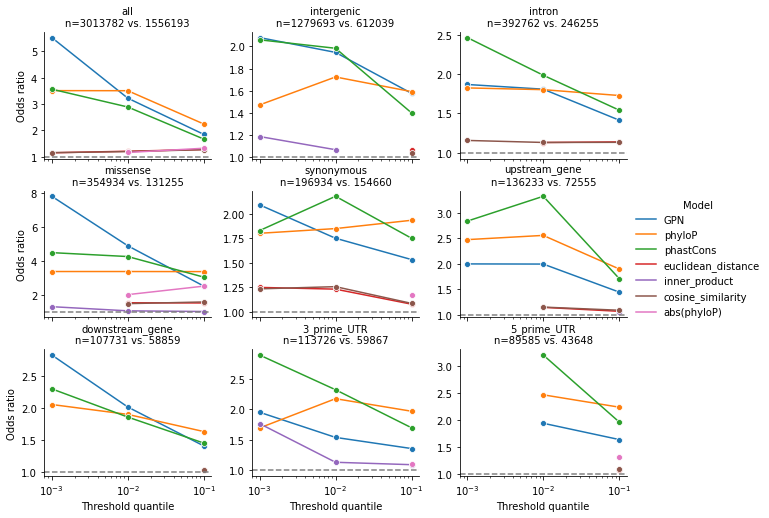

In [20]:
# """
g = sns.relplot(
    data=results[(results.p_value <= 0.05) & (results.above_limit)],
    x="Threshold quantile",
    y="Odds ratio",
    hue="Model",
    hue_order=models,
    col="subtitle",
    height=3,
    kind="line",
    marker="o",
    col_wrap=3,
    facet_kws={"sharey": False, "sharex": True},
)
for ax in g.axes:
    ax.axhline(1, ls="--", color="grey")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(xscale="log")
g.fig.subplots_adjust(top=0.75)
# plt.savefig("output/plots/vep_rare_vs_common_line.pdf", bbox_inches='tight')
# """

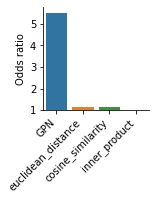

In [22]:
plt.figure(figsize=(1.9, 1.9))
g = sns.barplot(
    data=results[
        (results.p_value <= 0.05)
        & (results["Threshold quantile"] == 1e-3)
        & (results.Consequence == "all")
    ],
    y="Odds ratio",
    x="Model",
    # color="C0",
    order=["GPN", "euclidean_distance", "cosine_similarity", "inner_product"],
)
g.set(ylim=(1))
sns.despine()
plt.xlabel("")
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right");
# plt.savefig("output/plots/rare_vs_common_bar.svg", bbox_inches='tight');
# plt.savefig("output/plots/rare_vs_common_bar_repeat_weight.svg", bbox_inches='tight');
# plt.savefig("output/plots/rare_vs_common_bar_1_vs_0.01.svg", bbox_inches='tight');
# plt.savefig("output/plots/rare_vs_common_bar_5_vs_0.05.svg", bbox_inches='tight');
# plt.savefig("output/plots/rare_vs_common_bar_n_species.svg", bbox_inches='tight');

In [20]:
# results[(results.p_value<=0.05) & (results["Threshold quantile"]==1e-3) & (results.Consequence=="all")]

In [53]:
V

,chrom,pos,ref,alt,AC,AF,consequence,GPN,phyloP,phastCons,euclidean_distance,inner_product,cosine_similarity,abs(phyloP),Status
3,1,284,T,A,1,0.000493,intergenic,-0.779196,0.703100,-0.000292,-284.186218,17627580.0,0.997715,-0.703100,Rare
4,1,286,T,A,1,0.000493,intergenic,-0.048531,1.644564,-0.000070,-319.998108,17569016.0,0.997090,-1.644564,Rare
5,1,288,A,G,1,0.000493,intergenic,0.272360,-0.214873,-0.002629,-274.454010,17621930.0,0.997871,-0.214873,Rare
7,1,298,C,T,1,0.000493,intergenic,0.458471,-0.090109,-0.029638,-338.583069,17743892.0,0.996780,-0.090109,Rare
8,1,301,G,A,1,0.000493,intergenic,-0.007981,-0.189161,-0.005228,-314.551880,17777738.0,0.997224,-0.189161,Rare
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10697052,5,26975204,G,A,1,0.000493,intergenic,-1.733592,-0.743548,-0.010251,-329.383728,19975720.0,0.997220,-0.743548,Rare
10697056,5,26975213,C,T,1,0.000493,intergenic,0.106536,0.540382,-0.000073,-314.921295,20295910.0,0.997328,-0.540382,Rare
10697058,5,26975221,T,G,1,0.000493,intergenic,-3.305140,0.789413,-0.000323,-467.991638,20164728.0,0.994137,-0.789413,Rare
10697059,5,26975233,C,G,1,0.000493,intergenic,-4.791409,-0.773075,-0.285819,-384.926941,20052408.0,0.996308,-0.773075,Rare


In [54]:
2 + 2

4